In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [3]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')
spec_file = os.path.join(morph_folder, 'specs_star.p')

# load all dfs

In [16]:
all_pred = pickle.load(open(os.path.join(results_folder, 'extended', 'all_predicted_2pl.p'), 'rb'))
group1_behav = pickle.load(open(os.path.join(results_folder, 'group1_behav.p'), 'rb'))
group2_behav = pickle.load(open(os.path.join(results_folder, 'group2_behav.p'), 'rb'))
group3_behav = pickle.load(open(os.path.join(results_folder, 'group3_behav.p'), 'rb'))

In [17]:
all_groups = pd.concat([all_pred,
                       group1_behav, group2_behav, group3_behav]).reset_index(drop=True)

In [18]:
all_groups.head()

,index,slope,inflection,group,metric,min_val,max_val,subj
0,ae,0.028449,86.998390,Group 1,rmse,NaN,NaN,NaN
1,af,0.021558,61.000512,Group 1,rmse,NaN,NaN,NaN
2,ag,0.029138,52.000103,Group 1,rmse,NaN,NaN,NaN
3,ah,0.032490,54.001817,Group 1,rmse,NaN,NaN,NaN
4,bf,0.042703,92.274811,Group 1,rmse,NaN,NaN,NaN


(0.0, 1.0)

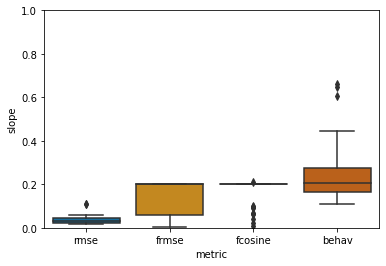

In [19]:
ax = sns.boxplot(y='slope', x='metric',data=all_groups)
ax.set_ylim([0,1])

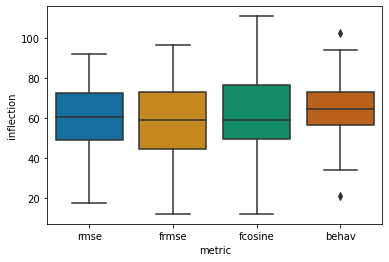

In [20]:
ax = sns.boxplot(y='inflection', x='metric',data=all_groups)

# separate by group

In [21]:
groups = ['Group 1', 'Group 2', 'Group 3']

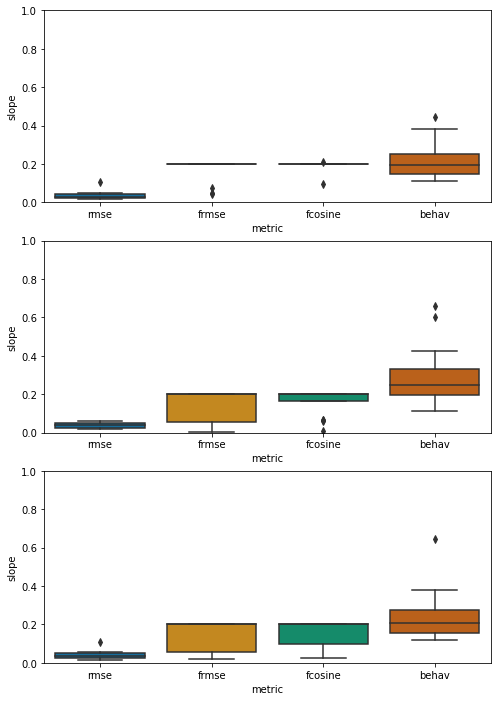

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='slope', x='metric',data=all_groups[all_groups.group==group], ax=ax[i])
    ax[i].set_ylim([0,1])

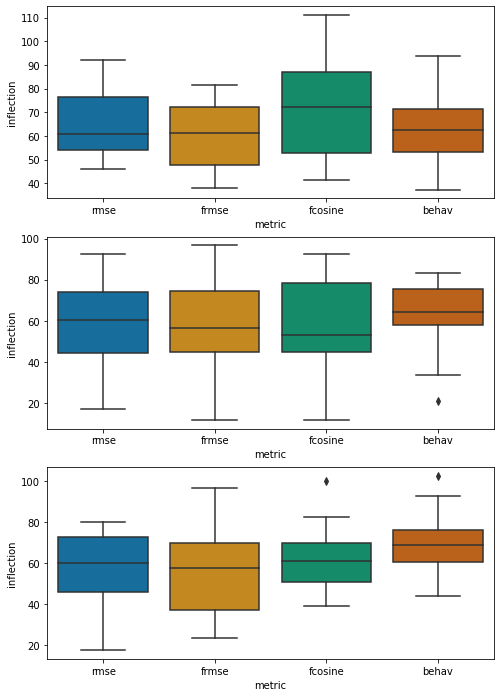

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='inflection', x='metric',data=all_groups[all_groups.group==group], ax=ax[i])

In [24]:
import statsmodels.formula.api as smf

In [25]:
all_groups.head()

,index,slope,inflection,group,metric,min_val,max_val,subj
0,ae,0.028449,86.998390,Group 1,rmse,NaN,NaN,NaN
1,af,0.021558,61.000512,Group 1,rmse,NaN,NaN,NaN
2,ag,0.029138,52.000103,Group 1,rmse,NaN,NaN,NaN
3,ah,0.032490,54.001817,Group 1,rmse,NaN,NaN,NaN
4,bf,0.042703,92.274811,Group 1,rmse,NaN,NaN,NaN


In [26]:
model = smf.mixedlm("slope ~ C(metric, Treatment('behav')) ",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM           Dependent Variable:           slope   
No. Observations:           266               Method:                       REML    
No. Groups:                 3                 Scale:                        0.0093  
Min. group size:            80                Log-Likelihood:               232.0874
Max. group size:            106               Converged:                    Yes     
Mean group size:            88.7                                                    
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 0.239    0.010  23.753 0.000  0.220  0.259
C(metric, Treatment('behav'))[T.fcosine] -0.071    0.017  -4.207 0.000 -0.104 -0.038
C(metric, Treatment('behav'))[T.frmse]   -0.093    0.017  -5.506 0.000 -0.126 -0.060
C(metric, Treatment('behav'))[T.rmse]    -0.202    0.017 -12.003 0.000 -0.235 -0.169
group Var                                 0.000    0.002                            
====================================================================================

"""

In [27]:
model = smf.mixedlm("inflection ~ C(metric, Treatment('behav')) ",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM          Dependent Variable:          inflection
No. Observations:           266              Method:                      REML      
No. Groups:                 3                Scale:                       300.9880  
Min. group size:            80               Log-Likelihood:              -1127.5571
Max. group size:            106              Converged:                   Yes       
Mean group size:            88.7                                                    
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                63.735    1.565 40.717 0.000  60.667 66.803
C(metric, Treatment('behav'))[T.fcosine] -1.017    3.005 -0.338 0.735  -6.906  4.873
C(metric, Treatment('behav'))[T.frmse]   -6.162    3.005 -2.051 0.040 -12.052 -0.272
C(metric, Treatment('behav'))[T.rmse]    -3.374    3.005 -1.123 0.262  -9.264  2.516
group Var                                 0.000    0.269                            
====================================================================================

"""